 This notebook was part of TestUVfromColdStart, just plot to see the RMS between original nowcast and that from cold start, with other conditions all the same. 

In [1]:
from matplotlib import pylab
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
import datetime 
import os
from salishsea_tools import nc_tools, viz_tools, tidetools, stormtools, bathy_tools
from salishsea_tools.nowcast import analyze

from __future__ import division
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

In [2]:
sites = {
    'Sandheads': {
        'lat': 49.10,
        'lon': -123.30,
        'i' : 77,##426 start from 349 fortran start from 350
        'j' : 34,##293 start from 259 fortran start from 260
    },
    'VENUS East':{
        'lat' : 49.0419,
        'lon' : -123.3176,
        'depth' : 170,
        'i' : 67,
        'j' : 24
    },    
    'VENUS Central': {
        'lat': 49.0401,
        'lon': -123.4261,
        'depth' : 300,
        'i': 75,
        'j': 7
        },

    'VENUS Delta': {
        'lat': 49.0807167,
        'lon': -123.3400617,
        'i':  76,
        'j':25
    },
    'S4-3':{
        'lat': 49.25 ,
        'lon':  -123.375,
        'i':112,
        'j': 41
        },
    }
# Font format
title_font = {
    'fontname': 'Bitstream Vera Sans', 'size': '20', 'color': 'black',
    'weight': 'medium'
}
axis_font = {'fontname': 'Bitstream Vera Sans', 'size': '18'}

In [11]:
grid_U = nc.Dataset('/data/jieliu/MEOPAR/river-treatment/14days_nowcast_allthesame/1hnowcastallthesame06160629gridU.nc')
u = grid_U.variables['vozocrtx']
print (u[:, 0 ,77:79, 34:38].shape)
uu= np.nanmean(u[:, 0 ,77:79, 34:38],axis = 2)
uuu = np.nanmean(uu,axis = 1)
print (uu.shape)
print(uuu.shape)
u_mine = np.nanmean(np.nanmean(u[:, 0 ,77:79, 34:38],axis = 2), axis = 1)
for i,j in zip(uuu, u_mine):
    if i-j!=0:
        print(i,j)

(336, 2, 4)
(336, 2)
(336,)


In [3]:
directory=['14days_nowcast_allthesame','15jun15']
bases=['/data/jieliu/MEOPAR/river-treatment/',\
      '/data/jieliu/MEOPAR/river-treatment/24hrs_nowcast_allthesame/15jun15/']
base_original = '/data/dlatorne/MEOPAR/SalishSea/nowcast/';
ufile_pattern = ['{}/1hnowcastallthesame06160629gridU.nc','{}/SalishSea_1h_20150615_20150615_grid_U.nc']
vfile_pattern = ['{}/1hnowcastallthesame06160629gridV.nc', '{}/SalishSea_1h_20150615_20150615_grid_V.nc']
Us={};Vs={}; 
##load my nowcasts
for base, u_pattern, v_pattern in zip(bases, ufile_pattern, vfile_pattern): 
    path = os.path.join(base,u_pattern.format(directory[0]))
    f = nc.Dataset(path,'r');
    Us[base] = f.variables['vozocrtx'][:]
    path = os.path.join(base,v_pattern.format(directory[0]))
    f = nc.Dataset(path,'r');
    Vs[base] = f.variables['vomecrty'][:]

##load original nowcasts from june 16-29
to = datetime.datetime(2015,6,16)
tf = datetime.datetime(2015,6,29)
j_list = []; i_list = []
for j in np.arange(898):
    j_list.append(j)
for i in np.arange(398):
    i_list.append(i)
#daily averages of original nowcasts
files_U = analyze.get_filenames(to,tf,'1h','grid_U',base_original)
u_daily, time_daily = analyze.combine_files(files_U, 'vozocrtx',0,j_list,i_list)
files_V = analyze.get_filenames(to,tf,'1h','grid_V',base_original)
v_daily, time_daily = analyze.combine_files(files_V, 'vomecrty',0,j_list, i_list)
##load separate original nowcast for june 15
path = os.path.join(base_original, ufile_pattern[1].format(directory[1]))
f = nc.Dataset(path,'r');
u_15daily = f.variables['vozocrtx'][:]
path = os.path.join(base_original, vfile_pattern[1].format(directory[1]))
f=nc.Dataset(path,'r');
v_15daily = f.variables['vomecrty'][:]

In [44]:
def rms(station,flag):
    ##create new time arange for the whole time period from june 15-29
    too = to.replace(day = 15)
    filess = analyze.get_filenames(too,tf,'1d','grid_T',base_original)
    none, time_dailyuse = analyze.combine_files(filess, 'vosaline',0,\
                    sites[station]['i']+349,sites[station]['j'] + 259)
    if flag ==0:
        add_relative=np.zeros(time_dailyuse.shape)
        rms_relative=np.zeros(time_dailyuse.shape)
        z= 1
    ## for june 16 to 29
        for i in np.arange(0, 336, 24):
            for j in np.arange(24):
                jj= i+j
                add_relative[z] = add_relative[z] +\
                (Us[bases[0]][jj, 0,sites[station]['i'], sites[station]['j']]-u_daily[jj, sites[station]['i']+349,\
                                                    sites[station]['j']+259])**2\
                +(Vs[bases[0]][jj, 0,sites[station]['i'], sites[station]['j']]-v_daily[jj, sites[station]['i']+349,\
                                                    sites[station]['j']+259])**2
            z = z+1
    ## added up june 15 
        for k in np.arange(24):
            add_relative[0] = add_relative[0]+(Us[bases[1]][k, 0,sites[station]['i'], sites[station]['j']]\
                                    - u_15daily[k,0, sites[station]['i']+349, sites[station]['j']+259])**2 +\
            (Vs[bases[1]][k,0,sites[station]['i'], sites[station]['j']]\
                                    - v_15daily[k,0,sites[station]['i']+349, sites[station]['j']+259])**2
        rms_relative[:] = np.sqrt(add_relative[:]/24)
    #if flag ==1:
        
    ## plot
    fig, axs = plt.subplots(1, 1, figsize=(12, 4))    
    
    axs.plot(time_dailyuse, rms_relative, linewidth = 2, marker ='.', color ='indigo')
    axs.grid('on')
    axs.set_ylim([0,0.6])
    axs.set_ylabel('RMS', **axis_font)
    return fig, rms_relative        

array([ 0.54108117,  0.13793847,  0.12479481,  0.07919916,  0.0616657 ,
        0.04247763,  0.05169903,  0.0714987 ,  0.05571202,  0.06068999,
        0.04308954,  0.0390322 ,  0.03347872,  0.02325042,  0.03585918])

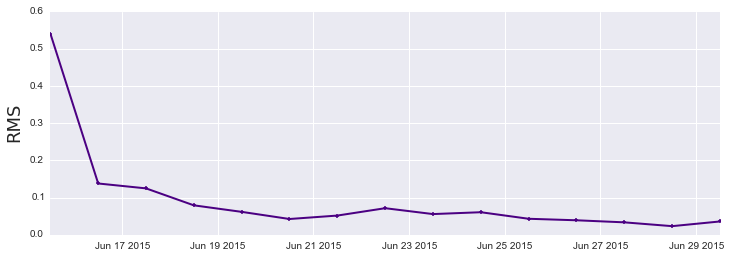

In [45]:
fig,rms_relative = rms( 'Sandheads',0)
rms_relative

array([ 0.43371508,  0.14601003,  0.1049512 ,  0.16057374,  0.14589991,
        0.09261624,  0.05881877,  0.06470654,  0.07354642,  0.10998443,
        0.14805397,  0.10046656,  0.04242766,  0.06344575,  0.08586033])

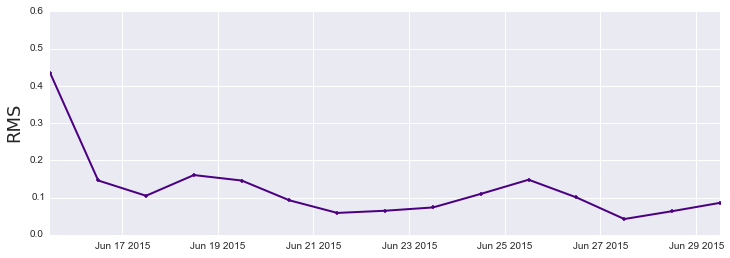

In [46]:
fig,rms_relative = rms( 'VENUS Central',0)
rms_relative

array([ 0.57845145,  0.18797102,  0.14805906,  0.11374913,  0.09258436,
        0.05673718,  0.06732115,  0.05664653,  0.0694209 ,  0.10376379,
        0.07779111,  0.0605067 ,  0.05326192,  0.04197228,  0.10033792])

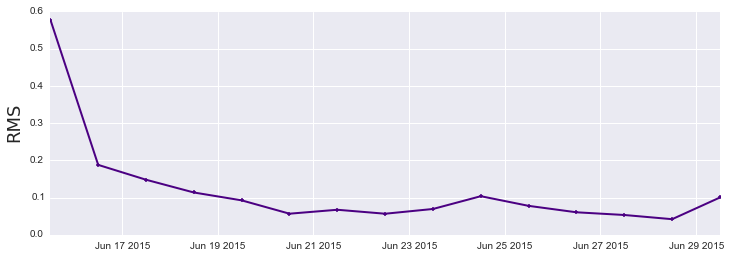

In [47]:
fig,rms_relative = rms( 'VENUS East',0)
rms_relative

array([ 0.5116848 ,  0.19477728,  0.18481649,  0.11018553,  0.07499676,
        0.06314369,  0.06420833,  0.06064148,  0.05857957,  0.07850425,
        0.05845177,  0.04993661,  0.04312018,  0.03179175,  0.15190678])

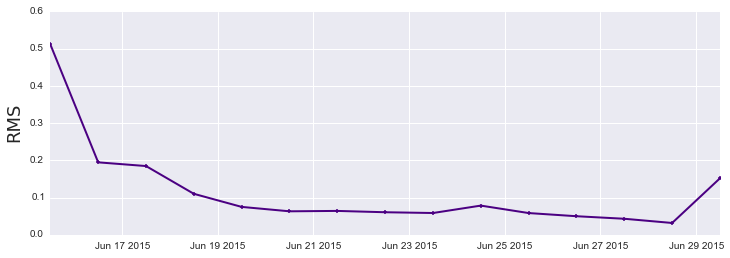

In [48]:
fig,rms_relative = rms( 'VENUS Delta',0)
rms_relative

array([ 0.19813081,  0.13544508,  0.10301592,  0.06858582,  0.06552722,
        0.07029007,  0.09202972,  0.08166975,  0.03616276,  0.02793106,
        0.01845002,  0.01864872,  0.02118506,  0.02563273,  0.06672652])

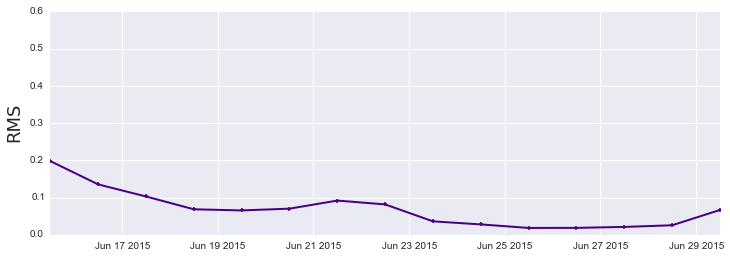

In [49]:
fig,rms_relative = rms( 'S4-3',0)
rms_relative